In [1]:
import numpy as np
import pandas as pd
from quasinet.qnet import qdistance, load_qnet
from emergenet.domseq import DomSeq, save_model, load_model
import os
import shutil

TAG='north_h3n2_ha_20'

In [2]:
Q_PATH='../../qnet_predictions/qnet_models/'+TAG+'.joblib'
import zipfile
with zipfile.ZipFile(Q_PATH+'.zip', 'r') as zip_ref:
    zip_ref.extractall(Q_PATH)
if os.path.isdir(Q_PATH):
    shutil.move(Q_PATH,Q_PATH+'D')
    shutil.copy(Q_PATH+'D/'+Q_PATH.split('/')[-1],Q_PATH)
    
qnet=load_qnet(Q_PATH)

os.remove(Q_PATH)
shutil. rmtree(Q_PATH+'D')

In [3]:
RAW_PATH='../../qnet_predictions/raw_data/gisaid/'

In [4]:
# initialize the DomSeq
domseq = DomSeq(seq_trunc_length=566, random_state=42)
df_north = domseq.load_data(filepath=RAW_PATH+TAG+'.fasta')

In [5]:
seq=df_north.set_index('id').sequence.values
S=[np.array(list(x)) for x in seq]

In [6]:
from scipy import stats as st
S_consensus=st.mode(S)[0][0]

In [7]:
import multiprocessing as mulpro
import itertools

In [8]:
s0__=S_consensus
qnet__=qnet

def fpar(s):
    return qdistance(s0__,s,qnet__,qnet__)

def f(s_array):
    pool = mulpro.Pool(processes=10)
    return np.array(pool.map(fpar, s_array))
    #return np.fromiter([qdistance(s0__,s,qnet__,qnet__) for s in s_array],dtype=np.float,count=len(s_array))
    

In [9]:
import shap
shap.initjs()

In [10]:
explainer = shap.KernelExplainer(f, np.array([S_consensus]))

In [11]:
S_=np.array([x for x in S if np.random.rand()<.6 ])
shap_values = explainer.shap_values(S_, nsamples=566)

  0%|          | 0/252 [00:00<?, ?it/s]

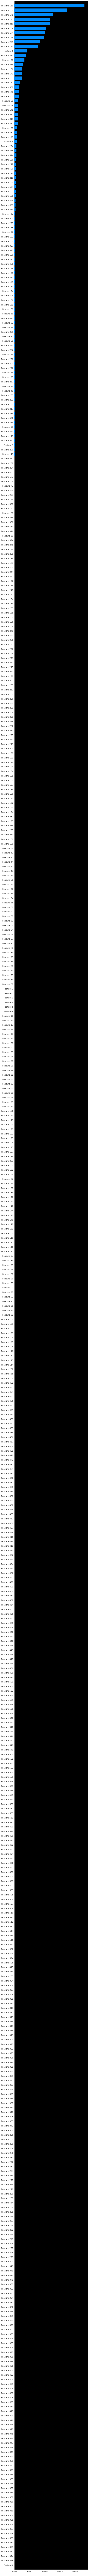

In [12]:
#shap.plots.bar(explainer(S__))
import pylab as plt
plt.style.use('dark_background')
shap.summary_plot(shap_values,S_, plot_type="bar",max_display=566)

In [13]:
nulldata=np.array([np.array(['']*566)])


In [14]:
explainerN = shap.KernelExplainer(f,nulldata)
#S_=np.array([x for x in S if np.random.rand()<.1 ])
shap_valuesN = explainerN.shap_values(S_, nsamples=566)

  0%|          | 0/252 [00:00<?, ?it/s]

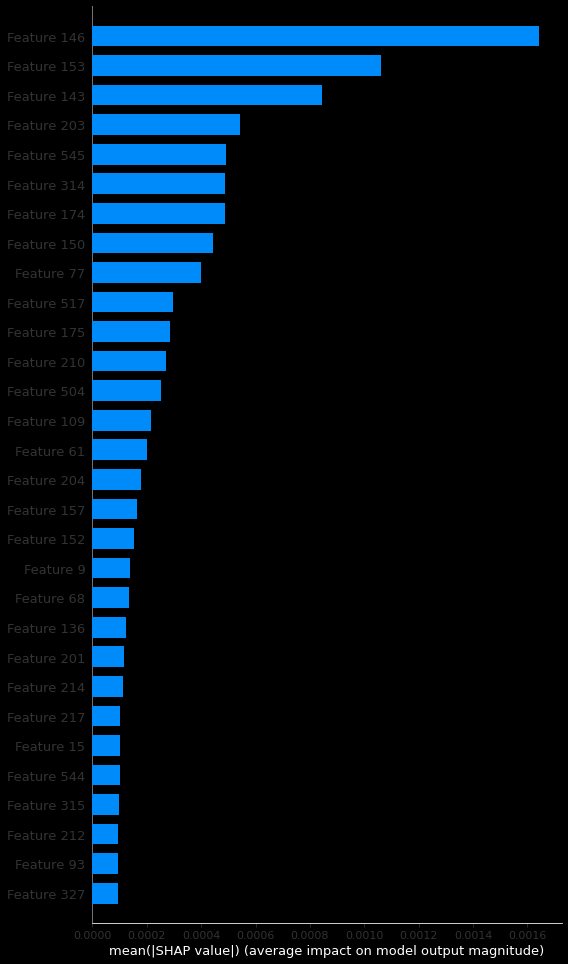

In [20]:
#shap.plots.bar(explainer(S__))
import pylab as plt
plt.style.use('dark_background')
shap.summary_plot(shap_valuesN,S_, plot_type="bar",max_display=30)

In [51]:
shp=pd.DataFrame(pd.DataFrame(shap_valuesN).abs().mean().sort_values(ascending=False),columns=['shp'])
shp.index.name='features'

#shpv=pd.DataFrame((2.6/np.sqrt(250))*pd.DataFrame(shap_valuesN).abs().std().sort_values(ascending=False),columns=['shpsd'])
#shpv.index.name='features'

#shp=shp.join(shpv)

<AxesSubplot:ylabel='features'>

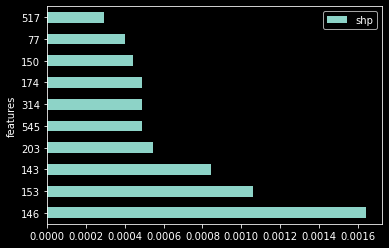

In [52]:
shp.head(10).plot(kind='barh')

<AxesSubplot:xlabel='features'>

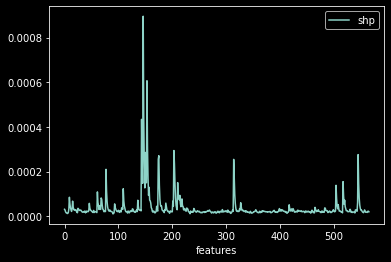

In [60]:
shp.sort_index().ewm(alpha=.5).mean().plot()